# Stochastic Diversity Evaluation for BCQ

Because BCQ is a generative model, it can generate different actions for the same state. This example code explores its capabilities of producing diverse, meaningful results.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import normalize

from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
frame_size = 10
tqdm.pandas()

In [3]:
frame_size = 10
batch_size = 1
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl", # cache will generate after you run
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

In [4]:
perturbator = recnn.nn.models.bcqPerturbator(1290, 128, 256).to(cuda)
generator = recnn.nn.models.bcqGenerator(1290, 128, 512).to(cuda)
perturbator.load_state_dict(torch.load('../../models/bcq_perturbator.pt'))
generator.load_state_dict(torch.load('../../models/bcq_generator.pt'))

<All keys matched successfully>

In [5]:
test_batch = next(iter(env.test_dataloader))
state, action, reward, next_state, done = recnn.data.get_base_batch(test_batch)

In [6]:
def rank(gen_action, metric):
    scores = []
    for i in movie_embeddings_key_dict.keys():
        scores.append([i, metric(movie_embeddings_key_dict[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = env.base.embeddings.detach().cpu().numpy().astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))


def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [7]:
# more than 5 actions don't work, the graphic looks ugly
# though you can change top k ranking
state = torch.repeat_interleave(state[0].unsqueeze(0), 5, dim=0)
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions

### Euclidean and cosine distances between generated actions for the same state

../../recnn/plot.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


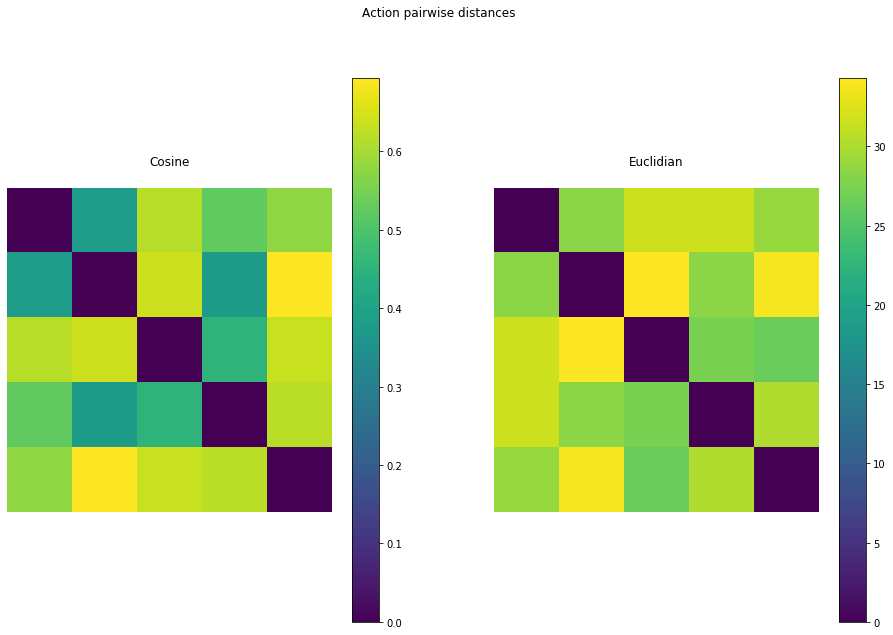

In [8]:
recnn.plot.pairwise_distances(bcq_action)

## PyUpSet
### bokeh version in the next section

In [28]:
# pip install upsetplot
from upsetplot import plot, from_memberships 

In [11]:
bcq_action = bcq_action.detach().cpu().numpy()

In [30]:
D, I = query(indexL2, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
    
cat = from_memberships(cat)

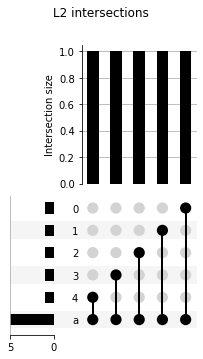

In [31]:
import warnings
warnings.filterwarnings("ignore")
plot(cat)
plt.suptitle('L2 intersections')
print()

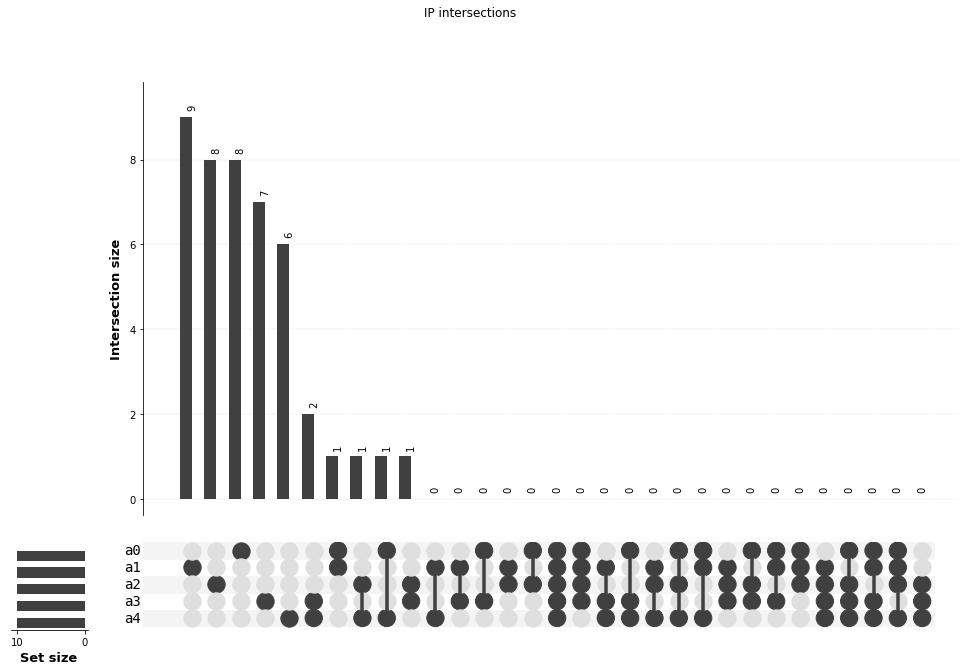

In [15]:
D, I = query(indexIP, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('IP intersections')
print()

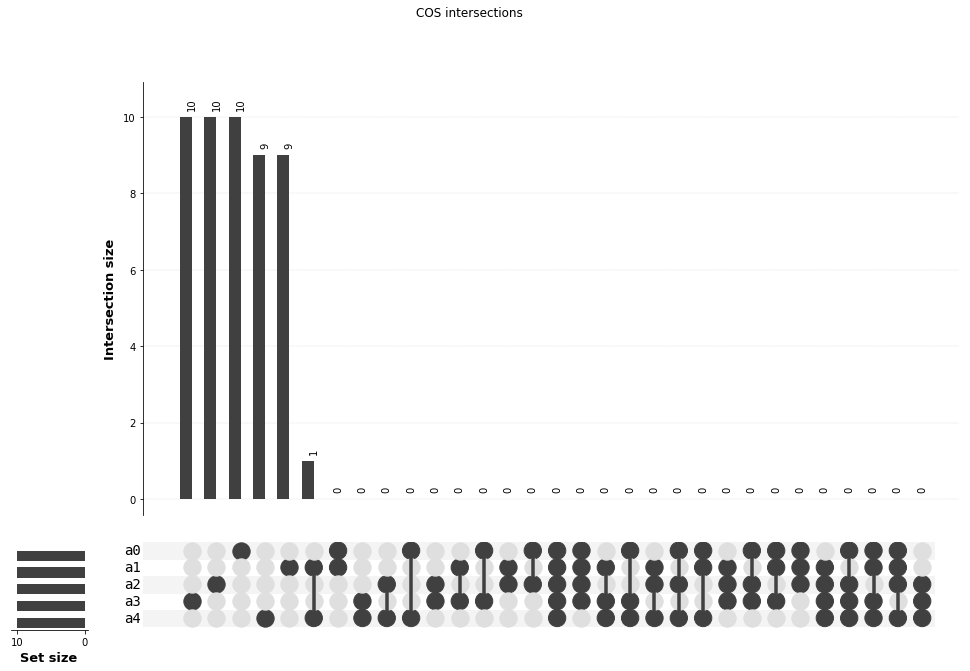

In [16]:
D, I = query(indexCOS, normalize(bcq_action, axis=1, norm='l2'), 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('COS intersections')
print()

## Distance Matrices

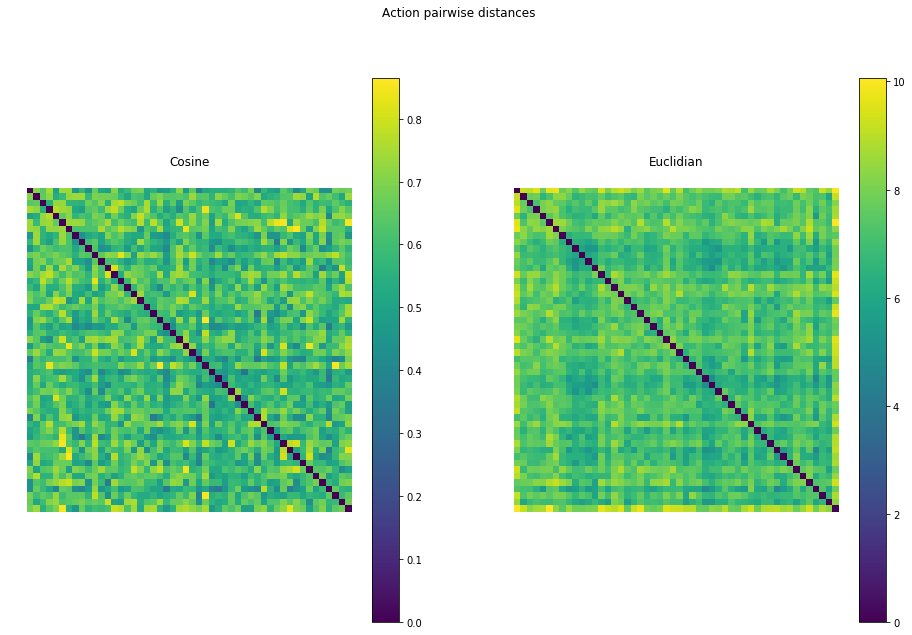

In [17]:
state = torch.repeat_interleave(state[0].unsqueeze(0), 50, dim=0)
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions
recnn.plot.pairwise_distances(bcq_action)

cosine dist is pretty small

# Holoviews Chord diagram

In [18]:
# can someone do this please?